In [1]:
import pandas as pd

from src.SemEvalData import SemEvalData
from src.JigsawData import JigsawData
from src.attention_exp import getWordsByAttention, wordAttentionWeights
from nltk import tokenize
import nltk
from keras.preprocessing.text import Tokenizer,  text_to_word_sequence
from keras.engine.topology import Layer
from keras import initializers as initializers, regularizers, constraints
from keras.callbacks import Callback, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding, Input, Dense, LSTM, GRU, Bidirectional, TimeDistributed, Dropout
from keras import backend as K
from keras import optimizers
from keras.models import Model
from src.Attention import Attention
import re
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, accuracy_score
from src.preprocessing import get_embeddings_index, get_embeddings_matrix,getSpansByToxicWords

In [2]:
##set to .env
MAX_FEATURES = 200000 # maximum number of unique words that should be included in the tokenized word index
MAX_WORD_NUM = 100     # maximum number of letters in sentence?
EMBED_SIZE = 300  ## same value as in dimension of glove
VAL_SPLIT = 0.2  
REG_PARAM = 1e-13
l2_reg = regularizers.l2(REG_PARAM)

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Julia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
## load data
train_data_semeval = SemEvalData(MAX_WORD_NUM)
data = train_data_semeval.load_data("data/tsd_trial.csv")
train_df_preprocessed = train_data_semeval.preprocess()

extra_train = JigsawData(MAX_WORD_NUM)
extra_train.load_data("data/train.csv")
extra_df_preprocessed = extra_train.preprocess()


In [5]:
print(train_df_preprocessed)
print(train_data_semeval.get_classes_amount(train_df_preprocessed))
##add data 
additional_data = extra_train.get_missing_class_elements(extra_df_preprocessed, 500, 0.0)
print(additional_data)
frames = [train_df_preprocessed, additional_data]
train_df_preprocessed = pd.concat(frames)
# train_df_preprocessed
print(train_data_semeval.get_classes_amount(train_df_preprocessed))

                                                 spans  \
0             [15, 16, 17, 18, 19, 27, 28, 29, 30, 31]   
1                             [29, 30, 31, 32, 33, 34]   
2                       [166, 167, 168, 169, 170, 171]   
3                             [87, 88, 89, 90, 91, 92]   
4                                                   []   
..                                                 ...   
685                     [129, 130, 131, 132, 133, 134]   
686                     [126, 127, 128, 129, 130, 131]   
687                           [24, 25, 26, 27, 28, 29]   
688  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...   
689                     [136, 137, 138, 139, 140, 141]   

                                                  text  toxicity  \
0    because hes a moron and a bigot. its not any m...         1   
1    how about we stop protecting idiots and let na...         1   
2    if people  were  smart, they would  boycott th...         1   
3    trump claimed that russia 

In [6]:
paras = []
labels = []
texts = []
sent_lens = []
sent_nums = []

##tokenize words
len_tr = len(train_df_preprocessed)
# result = train_df_preprocessed.append(extra_train_df, ignore_index=True, sort=False)
result = train_df_preprocessed
train_data = {
    'sentence':  result.sentences.sum(),
    'toxicity_sentence': result.toxicity_sentence.sum()
        }
print(train_data)

train_df = pd.DataFrame (train_data, columns = ['sentence','toxicity_sentence'])
###


{'sentence': ['because hes a moron and a bigot.', 'its not any more complicated than that.', 'how about we stop protecting idiots and let nature add some bleach to the gene pool.', 'we can always submit their names for the darwin awards.', 'if people  were  smart, they would  boycott this  inept  airline,  but   they  are  not  smart,  so   rogue  businesses  like  this  one,   still thrive   taking the idiots  for  a ride...', 'trump claimed that russia will never invade the ukraine, when russia already has - how stupid can people be?', 'as long as your willing to pay a lot more for products you buy, then fine.', 'but you better not be going to costco and walmart to buy stuff because its cheaper.', 'if so, we get to call you a hypocritical wanker.', 'only an idiot would use and believe anything this this republican propaganda machine publishes: www.realclearpolitics.com', 'thanks a lot douchebag.', 'youre the reason the portland buttfuckers are getting pushed out and moving down south

In [7]:
sentences =[]
for i in train_df.sentence:
    sentences.append(nltk.word_tokenize(i))

In [8]:
#filter token that are not alphabetic
sentences_filter=[]
for i, w in enumerate(sentences):
    sentences[i] = [word for word in sentences[i] if word.isalpha()]


In [9]:
#filter stop words- bez nich wyniki sie wiele nie roznia, a jest trudniej interpretowac- do przemyslenia
# nltk.download('stopwords')
# from nltk.corpus import stopwords
# stop_words = stopwords.words('english')
# for i, w in enumerate(sentences):
#     sentences[i] = [w for w in sentences[i] if not w in stop_words]

In [10]:
sentences = [x for x in sentences if x!=[]]

In [11]:
#flatten = lambda t: [item for sublist in t for item in sentences]

In [12]:
print(sentences)
tokenizer = Tokenizer(num_words=MAX_FEATURES, split=" ")
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
word_counts = tokenizer.word_counts
print(word_index, word_counts)

[['because', 'hes', 'a', 'moron', 'and', 'a', 'bigot'], ['its', 'not', 'any', 'more', 'complicated', 'than', 'that'], ['how', 'about', 'we', 'stop', 'protecting', 'idiots', 'and', 'let', 'nature', 'add', 'some', 'bleach', 'to', 'the', 'gene', 'pool'], ['we', 'can', 'always', 'submit', 'their', 'names', 'for', 'the', 'darwin', 'awards'], ['if', 'people', 'were', 'smart', 'they', 'would', 'boycott', 'this', 'inept', 'airline', 'but', 'they', 'are', 'not', 'smart', 'so', 'rogue', 'businesses', 'like', 'this', 'one', 'still', 'thrive', 'taking', 'the', 'idiots', 'for', 'a', 'ride'], ['trump', 'claimed', 'that', 'russia', 'will', 'never', 'invade', 'the', 'ukraine', 'when', 'russia', 'already', 'has', 'how', 'stupid', 'can', 'people', 'be'], ['as', 'long', 'as', 'your', 'willing', 'to', 'pay', 'a', 'lot', 'more', 'for', 'products', 'you', 'buy', 'then', 'fine'], ['but', 'you', 'better', 'not', 'be', 'going', 'to', 'costco', 'and', 'walmart', 'to', 'buy', 'stuff', 'because', 'its', 'cheaper'

In [13]:
import gensim
word_vectors = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin', binary=True, limit = 1000000) 

In [14]:
EMBEDDING_DIM = 300
vocabulary_size=min(len(word_index)+1,MAX_FEATURES)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))

In [15]:
absent_words =0
for word, i in word_index.items():
    if i>=MAX_FEATURES:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i]=np.random.normal(0,np.sqrt(0.25),EMBEDDING_DIM)
        absent_words+=1

In [16]:
data_index = np.zeros((len(sentences), MAX_WORD_NUM), dtype='int32')
for i, sentence in enumerate(sentences):
    for k, word in enumerate(sentence):
        try:
            if k<MAX_WORD_NUM and tokenizer.word_index[word]<MAX_FEATURES:
                data_index[i,k] = tokenizer.word_index[word]
        except:
            #print(word)
            pass

In [17]:
print(data_index[:5])
indices = np.arange(data_index.shape[0])
np.random.shuffle(indices)
data = data_index[indices].copy()
##IMPORTANT
data = data.astype(np.float32)
labels = train_df.toxicity_sentence.iloc[indices]
# labels = labels.astype(np.float32)
nb_validation_samples = int(VAL_SPLIT * data.shape[0])
x_train = data[:-nb_validation_samples]
y_train = np.vstack(labels[:-nb_validation_samples])
x_val = data[-nb_validation_samples:]
y_val = np.vstack(labels[-nb_validation_samples:])

[[  75  195    5  337    3    5 1802    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  49   15   56   59 3697   95    9    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0

In [18]:
embedding_layer = Embedding(len(word_index)+1 ,EMBED_SIZE,weights=[embedding_matrix], input_length=MAX_WORD_NUM, trainable= True, name='embedding')
word_input = Input(shape=MAX_WORD_NUM, dtype='float32', name='input')
word_sequences = embedding_layer(word_input)
word_lstm = Bidirectional(LSTM(40, return_sequences=True, kernel_regularizer=l2_reg), name='bidirectional')(word_sequences)
word_dense = Dense(70, kernel_regularizer=l2_reg, name='dense')(word_lstm)
word_att = Dropout(0.2)(Attention(name='attention')(word_dense))#
preds = Dense(1, activation='relu', name='dense_final')(word_att) ##softmax, elu?
model = Model(word_input, preds)
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['acc']) ##adam
checkpoint = ModelCheckpoint('best_model_embeddings.h5', verbose=-2, monitor='val_loss',save_best_only=True, mode='auto')
print(model.summary())

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          2457600   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 80)           109120    
_________________________________________________________________
dense (Dense)                (None, 100, 70)           5670      
_________________________________________________________________
attention (Attention)        (None, 70)                5040      
_________________________________________________________________
dropout (Dropout)            (None, 70)                0         
_________________________________________________________________
dense_final (Dense)          (None, 1)                

Epoch 1/25
4/4 [==============================] - 4s 1s/step - loss: 0.6821 - acc: 0.8039 - val_loss: 0.4914 - val_acc: 0.8086
Epoch 2/25
4/4 [==============================] - 3s 812ms/step - loss: 0.4953 - acc: 0.8058 - val_loss: 0.4842 - val_acc: 0.8086
Epoch 3/25
4/4 [==============================] - 3s 797ms/step - loss: 0.4816 - acc: 0.8058 - val_loss: 0.4761 - val_acc: 0.8086
Epoch 4/25
4/4 [==============================] - 3s 824ms/step - loss: 0.4670 - acc: 0.8064 - val_loss: 0.4663 - val_acc: 0.8086
Epoch 5/25
4/4 [==============================] - 3s 794ms/step - loss: 0.4444 - acc: 0.8064 - val_loss: 0.4837 - val_acc: 0.8086
Epoch 6/25
4/4 [==============================] - 3s 846ms/step - loss: 0.4276 - acc: 0.8098 - val_loss: 0.4592 - val_acc: 0.8086
Epoch 7/25
4/4 [==============================] - 3s 795ms/step - loss: 0.3833 - acc: 0.8117 - val_loss: 0.5474 - val_acc: 0.8086
Epoch 8/25
4/4 [==============================] - 3s 793ms/step - loss: 0.3495 - acc: 0.8372 

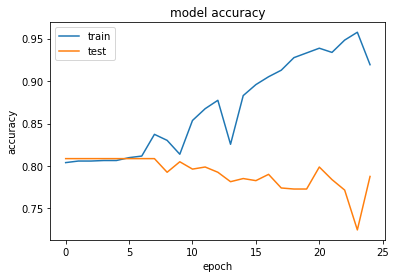

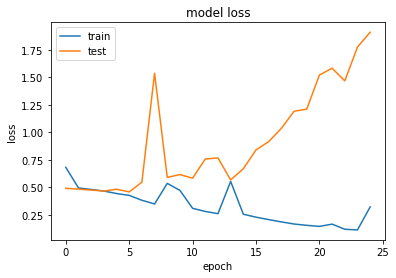

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: attention_model\assets


NameError: name 'moddel' is not defined

In [19]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=1024,shuffle=True, callbacks=[checkpoint])
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save('attention_model')
model.save('attention_model.h5')


In [20]:
model.save('attention_model.h5')

In [ ]:



# Create model from word input to output of dense layer right before the attention layer
# print( model.get_layer('time_distributed').output.shape,  len(model.get_layer('dense_final').get_weights()))
hidden_word_encoding_out = Model(inputs=model.input, outputs= model.get_layer('dense').output)
# Load weights from trained attention layer
word_context = model.get_layer('attention').get_weights()
# hidden_word_encodings = hidden_word_encoding_out.predict(word_input_array)
# # Compute context vector using output of dense layer
# ait = wordAttentionWeights(hidden_word_encodings,word_context)
TRESHOLD = 0.016 

In [ ]:
for i in range(0,20):
    #print('data',data[i])
    in_data =data_index[i].reshape(1,MAX_WORD_NUM)
    y = model.predict(in_data)
    hidden_word_encodings = hidden_word_encoding_out.predict(in_data)
     # Compute context vector using output of dense layer
    ait = wordAttentionWeights(hidden_word_encodings,word_context)
    print(ait)
    toxic = getWordsByAttention(ait,in_data, train_df.iloc[i].sentence,TRESHOLD)
    spans = getSpansByToxicWords(toxic,train_df.iloc[i].sentence)
    print('attention',(train_df.iloc[i].sentence, toxic, spans))